<a href="https://colab.research.google.com/github/martintmv-git/RB-IBDM/blob/main/Experiments/Segment%20Anything/Finetuning/InsectSAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# InsectSAM

In this notebook, we'll fine-tune `segment-anything` on a dataset of insect images and their corresponding masks for the RB-IBDM project.

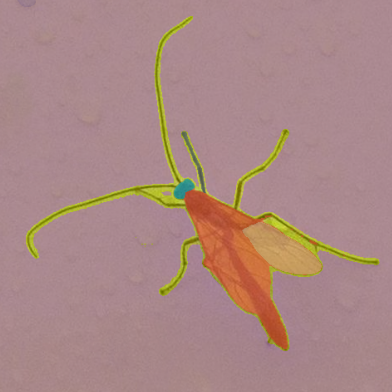

Resources used to create this notebook (thanks):

#### [Segment Anything](https://segment-anything.com/)
#### [Finetune SAM Blog](https://encord.com/blog/learn-how-to-fine-tune-the-segment-anything-model-sam/)
#### [MedSAM repository](https://github.com/bowang-lab/MedSAM)

In [1]:
!pip install transformers
!pip install -q monai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 14.5 MB/s eta 0:00:00


In [2]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from torchvision import transforms

In [4]:
import torch
import torchvision
import torchvision.transforms as T

In [5]:
transform = T.Resize((256, 256))

(-0.5, 255.5, 255.5, -0.5)

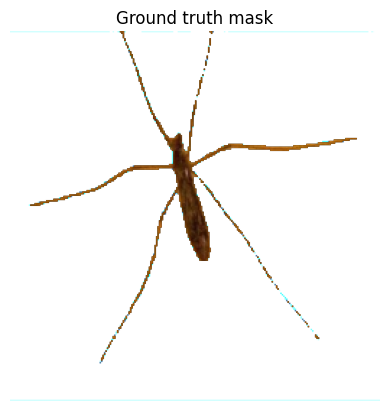

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

fig, axes = plt.subplots()

image = transform(Image.open('/content/drive/MyDrive/diopsis_tests/finetune-dataset/image/9.jpg'))
label = transform(Image.open('/content/drive/MyDrive/diopsis_tests/finetune-dataset/label/9.png'))

axes.imshow(np.array(image))
ground_truth_seg = np.array(label)
show_mask(ground_truth_seg, axes)
axes.title.set_text(f"Ground truth mask")
axes.axis("off")

In [7]:
ground_truth_seg.shape

(256, 256)

In [8]:
def get_bounding_box(ground_truth_map):
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

In [9]:
label = Image.open('/content/drive/MyDrive/diopsis_tests/finetune-dataset/label/25.png')
ground_truth_seg = np.array(label)
testing = get_bounding_box(ground_truth_seg)

In [10]:
import os
seg_dir_list = os.listdir('/content/drive/MyDrive/diopsis_tests/finetune-dataset/label')
img_dir_list = os.listdir('/content/drive/MyDrive/diopsis_tests/finetune-dataset/image')

In [11]:
data = []
for i in range(0, 264):
  img_temp = img_dir_list[i]
  for segitem in seg_dir_list:
    if(segitem.startswith(img_temp.split('.')[0])):
      data.append({'img':img_dir_list[i],'seg':segitem})
print(data)

[{'img': '238.jpg', 'seg': '238.png'}, {'img': '195.jpg', 'seg': '195.png'}, {'img': '22.jpg', 'seg': '22.png'}, {'img': '22.jpg', 'seg': '228.png'}, {'img': '22.jpg', 'seg': '229.png'}, {'img': '22.jpg', 'seg': '221.png'}, {'img': '22.jpg', 'seg': '220.png'}, {'img': '22.jpg', 'seg': '222.png'}, {'img': '22.jpg', 'seg': '223.png'}, {'img': '22.jpg', 'seg': '227.png'}, {'img': '22.jpg', 'seg': '226.png'}, {'img': '22.jpg', 'seg': '224.png'}, {'img': '22.jpg', 'seg': '225.png'}, {'img': '35.jpg', 'seg': '35.png'}, {'img': '42.jpg', 'seg': '42.png'}, {'img': '43.jpg', 'seg': '43.png'}, {'img': '50.jpg', 'seg': '50.png'}, {'img': '68.jpg', 'seg': '68.png'}, {'img': '81.jpg', 'seg': '81.png'}, {'img': '90.jpg', 'seg': '90.png'}, {'img': '109.jpg', 'seg': '109.png'}, {'img': '146.jpg', 'seg': '146.png'}, {'img': '175.jpg', 'seg': '175.png'}, {'img': '178.jpg', 'seg': '178.png'}, {'img': '179.jpg', 'seg': '179.png'}, {'img': '183.jpg', 'seg': '183.png'}, {'img': '184.jpg', 'seg': '184.png'},

In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [13]:
from torch.utils.data import Dataset

class SAMDataset(Dataset):
    def __init__(self, dataset, processor, image_folder, label_folder):
        self.dataset = dataset
        self.processor = processor
        self.image_folder = image_folder
        self.label_folder = label_folder

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        image_path = os.path.join(self.image_folder, str(idx + 1) + ".jpg")
        label_path = os.path.join(self.label_folder, str(idx + 1) + ".png")

        image = transform(Image.open(image_path))
        ground_truth_mask = np.array(transform(Image.open(label_path)))

        # get bounding box prompt
        prompt = get_bounding_box(ground_truth_mask)

        # prepare image and prompt for the model
        inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt").to(device)

        # remove batch dimension which the processor adds by default
        inputs = {k: v.squeeze(0) for k, v in inputs.items()}

        # add ground truth segmentation
        inputs["ground_truth_mask"] = ground_truth_mask

        return inputs

In [14]:
from transformers import SamProcessor

processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

In [15]:
from transformers import SamModel
model = SamModel.from_pretrained("facebook/sam-vit-base").to(device)

config.json:   0%|          | 0.00/6.57k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/375M [00:00<?, ?B/s]

In [16]:
image_folder = "/content/drive/MyDrive/diopsis_tests/finetune-dataset/image"
label_folder = "/content/drive/MyDrive/diopsis_tests/finetune-dataset/label"

# Create the train_dataset instance with the specified arguments
train_dataset = SAMDataset(dataset=data, processor=processor, image_folder=image_folder, label_folder=label_folder)

In [17]:
example = train_dataset[0]
for k,v in example.items():
  print(k,v.shape)

pixel_values torch.Size([3, 1024, 1024])
original_sizes torch.Size([2])
reshaped_input_sizes torch.Size([2])
input_boxes torch.Size([1, 4])
ground_truth_mask (256, 256)


In [18]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)

In [35]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k,v.shape)

pixel_values torch.Size([2, 3, 1024, 1024])
original_sizes torch.Size([2, 2])
reshaped_input_sizes torch.Size([2, 2])
input_boxes torch.Size([2, 1, 4])
ground_truth_mask torch.Size([2, 256, 256])


In [36]:
batch["ground_truth_mask"].shape

torch.Size([2, 256, 256])

In [37]:
for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)

In [38]:
from torch.optim import Adam
import monai

# Note: Hyperparameter tuning could improve performance here
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)

seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

In [47]:
# work on this more, something is wrong with training

from tqdm import tqdm
from statistics import mean
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import random

class CustomImageDataset(Dataset):
    def __init__(self, img_dir, transform=None, mask_transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.mask_transform = mask_transform
        self.img_ids = list(range(1, 267))  # Image IDs from 1 to 266

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        img_id = random.choice(self.img_ids)  # Randomly select an image ID
        img_path = f"{self.img_dir}/{img_id}.jpg"
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)  # Apply transformation to convert image to tensor

        ground_truth_mask = torch.rand((256, 256))  # Directly generates a tensor

        return {
            "pixel_values": image,
            "ground_truth_mask": ground_truth_mask,
        }

num_epochs = 4
img_dir = '/content/drive/MyDrive/diopsis_tests/finetune-dataset/image'

transform = transforms.Compose([
    transforms.Resize((1024, 1024)),
    transforms.ToTensor(),
])

train_dataset = CustomImageDataset(img_dir=img_dir, transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()
for epoch in range(num_epochs):
    epoch_losses = []
    for batch in tqdm(train_dataloader):
        # forward pass
        outputs = model(pixel_values=batch["pixel_values"].to(device),
                        multimask_output=False)

        # compute loss
        predicted_masks = outputs.pred_masks.squeeze(1)
        ground_truth_masks = batch["ground_truth_mask"].float().to(device)
        loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))

        # backward pass
        optimizer.zero_grad()
        loss.backward()

        # optimize
        optimizer.step()
        epoch_losses.append(loss.item())

    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean(epoch_losses)}')

100%|██████████| 34/34 [00:29<00:00,  1.14it/s]


EPOCH: 0
Mean loss: 0.8459557014353135


100%|██████████| 34/34 [00:29<00:00,  1.15it/s]


EPOCH: 1
Mean loss: 0.8345669472918791


100%|██████████| 34/34 [00:29<00:00,  1.16it/s]


EPOCH: 2
Mean loss: 0.8335160332567552


100%|██████████| 34/34 [00:29<00:00,  1.16it/s]

EPOCH: 3
Mean loss: 0.833156357793247


In [57]:
# save the model
model_save_path = '/content/drive/MyDrive/diopsis_tests/InsectSAM_model/InsectSAM.pth'
os.makedirs(os.path.dirname(model_save_path), exist_ok=True)
torch.save(model.state_dict(), model_save_path)
print(f'Model saved to {model_save_path}')

Model saved to /content/drive/MyDrive/diopsis_tests/InsectSAM_model/InsectSAM.pth


In [97]:
from PIL import Image

# Let's take a random training example
idx = 177

# Load image
image_path = os.path.join(image_folder, str(idx + 1) + ".jpg")
image = Image.open(image_path)

image.show()

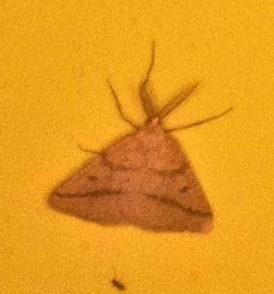

In [98]:
image

In [91]:
model.eval()

SamModel(
  (shared_image_embedding): SamPositionalEmbedding()
  (vision_encoder): SamVisionEncoder(
    (patch_embed): SamPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (layers): ModuleList(
      (0-11): 12 x SamVisionLayer(
        (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionAttention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (layer_norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): SamMLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (neck): SamVisionNeck(
      (conv1): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (layer_norm1): SamLayerNorm()
     

In [ ]:
# apply sigmoid
medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
# convert soft mask to hard mask
medsam_seg_prob = medsam_seg_prob.cpu().tensor.detach().numpy().squeeze()
medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)

(-0.5, 273.5, 293.5, -0.5)

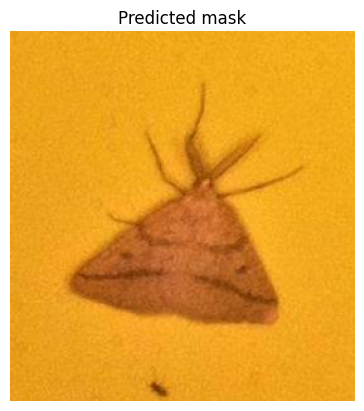

In [99]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

fig, axes = plt.subplots()

axes.imshow(np.array(image))
axes.title.set_text(f"Predicted mask")
axes.axis("off")

(-0.5, 1023.5, 1023.5, -0.5)

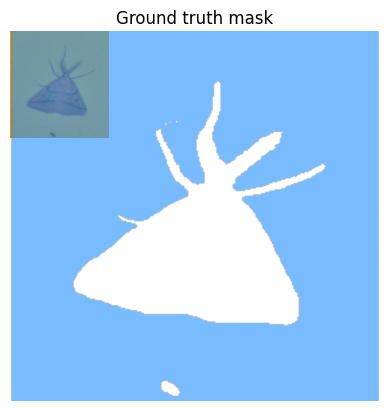

In [100]:
fig, axes = plt.subplots()

axes.imshow(np.array(image))
show_mask(ground_truth_mask, axes)
axes.title.set_text(f"Ground truth mask")
axes.axis("off")